In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [24]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension → (28, 28, 1)
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test  = np.reshape(x_test, (-1, 28, 28, 1))

In [25]:
latent_dim = 32

In [26]:
encoder_inputs = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


In [27]:
def sample_latent(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sample_latent)([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3136)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │     50,192 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │        544 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │        544 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,096 (273.81 KB)

 Trainable params: 70,096 (273.81 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
latent_inputs = layers.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)

x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(inputs, reconstructed)
        )

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        self.add_loss(recon_loss + kl_loss)
        return reconstructed


In [30]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

vae.fit(x_train, epochs=100, batch_size=128, validation_data=(x_test, None))


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.2847 - val_loss: 0.2654
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.2649 - val_loss: 0.2642
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2641 - val_loss: 0.2637
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.2638 - val_loss: 0.2634
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.2636 - val_loss: 0.2637
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.2635 - val_loss: 0.2632
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.2634 - val_loss: 0.2634
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2634 - val_loss: 0.2629
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2633 - val_loss: 0.2629
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2632 - val_loss: 0.2631
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2632 - val_loss: 0.2628
Epoch 12/100
469/46

In [31]:
_, _, z = encoder.predict(x_test)
reconstructed = decoder.predict(z)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [32]:
# Sample random latent points
z_random = np.random.normal(size=(10, latent_dim))

generated_images = decoder.predict(z_random)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


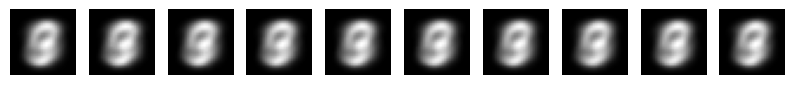

In [34]:
plt.figure(figsize=(10, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.show()
